# The Payne Tutorial: Stellar Parameter Determination with Neural Networks

**Welcome!** This tutorial will guide you through using The Payne to:
1. 🔮 **Predict stellar spectra** from physical parameters
2. 🎯 **Fit observed spectra** to determine stellar parameters  
3. 🧠 **Train custom neural networks** on spectral grids

---

## Table of Contents
1. [Introduction & Setup](#introduction)
2. [Use Case 1: Predicting Stellar Spectra](#use-case-1)
3. [Use Case 2: Fitting Observed Spectra](#use-case-2)
4. [Use Case 3: Training Neural Networks](#use-case-3)
5. [Advanced Topics](#advanced)
6. [Summary & Best Practices](#summary)

<a id='introduction'></a>
## 1. Introduction & Setup

### What is The Payne?

The Payne uses **neural networks** to learn the relationship between stellar parameters (temperature, surface gravity, chemical abundances) and their spectra. This allows for:
- **Fast spectrum generation** (milliseconds vs hours for physics models)
- **Accurate parameter fitting** with uncertainty estimates
- **25+ stellar parameters** including detailed abundances

### The Class-Based Interface

The Payne provides three main classes:
- **`PaynePredictor`**: Generate synthetic spectra
- **`PayneFitter`**: Fit observed spectra
- **`PayneTrainer`**: Train new models

Let's get started!

In [1]:
# Import required packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Configure plots for better visualization
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 11

# Import The Payne classes
from The_Payne import PaynePredictor, PayneFitter, PayneTrainer
from The_Payne import utils

print("✓ Imports successful!")

✓ Imports successful!


<a id='use-case-1'></a>
## 2. Use Case 1: Predicting Stellar Spectra

In this section, we'll learn how to generate synthetic stellar spectra from physical parameters.

### 2.1 Initialize the Predictor

In [2]:
# Create a predictor instance
predictor = PaynePredictor()

# Display information about the loaded model
print(predictor)
print(f"\nThe model predicts {predictor.num_pixels} wavelength pixels")
print(f"Wavelength range: {predictor.wavelength[0]:.2f} - {predictor.wavelength[-1]:.2f} Å")

PaynePredictor(num_labels=25, num_pixels=7214, wavelength_range=[15168.13, 16936.75] Å)

The model predicts 7214 wavelength pixels
Wavelength range: 15168.13 - 16936.75 Å


### 2.2 Understanding Stellar Labels

The Payne works with **25 stellar labels**. Let's see what they are:

In [3]:
# Get the label names
label_names = predictor.get_label_names()

print("Stellar labels (total: 25):")
print("\nPhysical Parameters:")
for i, name in enumerate(label_names[:3]):
    print(f"  {i}: {name}")

print("\nChemical Abundances:")
for i, name in enumerate(label_names[3:23], start=3):
    print(f"  {i}: {name}", end="  ")
    if (i-2) % 5 == 0:
        print()

print("\n\nOther Parameters:")
for i, name in enumerate(label_names[23:], start=23):
    print(f"  {i}: {name}")

Stellar labels (total: 25):

Physical Parameters:
  0: Teff
  1: logg
  2: Vturb

Chemical Abundances:
  3: [C/H]    4: [N/H]    5: [O/H]    6: [Na/H]    7: [Mg/H]  
  8: [Al/H]    9: [Si/H]    10: [P/H]    11: [S/H]    12: [K/H]  
  13: [Ca/H]    14: [Ti/H]    15: [V/H]    16: [Cr/H]    17: [Mn/H]  
  18: [Fe/H]    19: [Co/H]    20: [Ni/H]    21: [Cu/H]    22: [Ge/H]  


Other Parameters:
  23: C12/C13
  24: Vmacro


### 2.3 Example 1: Solar-Type Star

Let's predict the spectrum of a star similar to our Sun.

In [4]:
# Get default labels (mid-range values)
solar_labels = predictor.get_default_labels()

# Set solar parameters
solar_labels[0] = 5777   # Teff (K)
solar_labels[1] = 4.44   # logg (cgs)
solar_labels[2] = 1.0    # Vturb (km/s)
solar_labels[18] = 0.0   # [Fe/H] = 0.0 (solar metallicity)

# Predict spectrum with radial velocity
solar_spectrum = predictor.predict_spectrum(solar_labels, rv=30.0)

print("✓ Solar spectrum predicted!")
print(f"  Spectrum shape: {solar_spectrum.shape}")
print(f"  Flux range: {solar_spectrum.min():.4f} - {solar_spectrum.max():.4f}")

✓ Solar spectrum predicted!
  Spectrum shape: (7214,)
  Flux range: 0.6904 - 1.0317


### 2.4 Visualize the Solar Spectrum

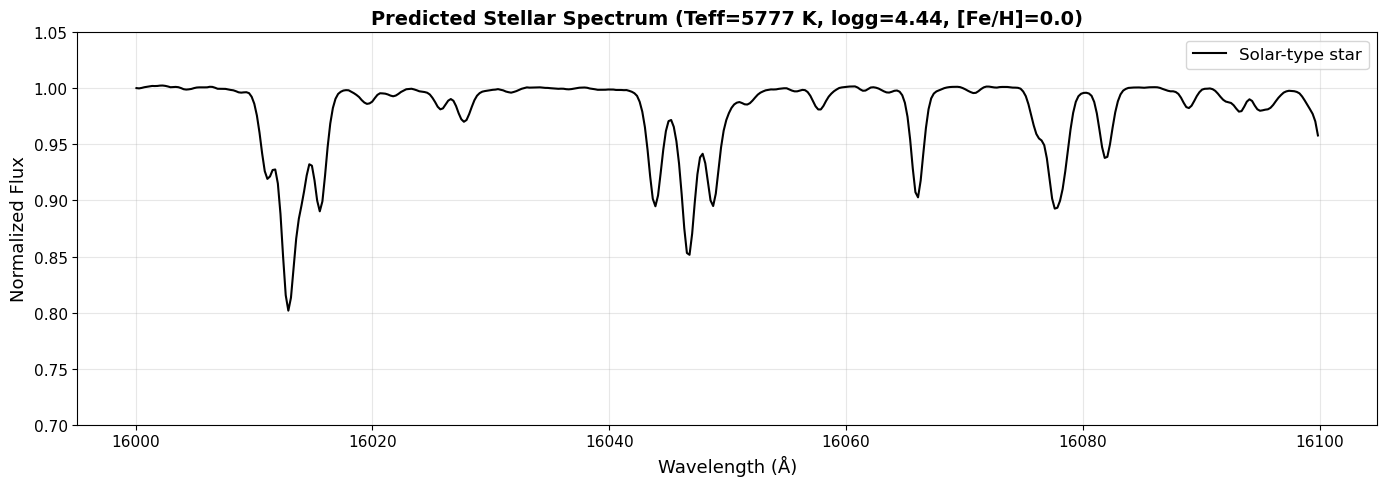

In [5]:
# Plot a region of the spectrum
wavelength = predictor.get_wavelength()
wave_min, wave_max = 16000, 16100
mask = (wavelength >= wave_min) & (wavelength <= wave_max)

plt.figure(figsize=(14, 5))
plt.plot(wavelength[mask], solar_spectrum[mask], 'k-', lw=1.5, label='Solar-type star')
plt.xlabel('Wavelength (Å)', fontsize=13)
plt.ylabel('Normalized Flux', fontsize=13)
plt.title('Predicted Stellar Spectrum (Teff=5777 K, logg=4.44, [Fe/H]=0.0)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.ylim(0.7, 1.05)
plt.tight_layout()
plt.show()

---
<a id='use-case-2'></a>
## 3. Use Case 2: Fitting Observed Spectra

Now we'll learn how to **fit observed spectra** to determine stellar parameters.

### 3.1 Initialize the Fitter

In [6]:
# Create a fitter instance
fitter = PayneFitter(use_mask=True)

print(fitter)
print(f"\nMasked pixels: {np.sum(fitter.mask)} ({100*np.sum(fitter.mask)/len(fitter.mask):.1f}%)")

PayneFitter(num_labels=25, masked_pixels=12.1%)

Masked pixels: 875 (12.1%)


### 3.2 Create a Synthetic "Observed" Spectrum

We'll generate a spectrum with known parameters and add noise.

In [7]:
# Define "true" parameters
true_labels = predictor.get_default_labels()
true_labels[0] = 5800    # Teff
true_labels[1] = 4.2     # logg
true_labels[18] = -0.3   # [Fe/H]
true_rv = 45.0

# Generate spectrum with noise
true_spectrum = predictor.predict_spectrum(true_labels, rv=true_rv)
np.random.seed(42)
noise_level = 0.01
observed_spectrum = true_spectrum + np.random.normal(0, noise_level, len(true_spectrum))
spec_err = np.ones_like(observed_spectrum) * noise_level

print("✓ Synthetic 'observed' spectrum created!")
print(f"True: Teff={true_labels[0]:.0f} K, logg={true_labels[1]:.2f}, [Fe/H]={true_labels[18]:.2f}, RV={true_rv:.1f} km/s")

✓ Synthetic 'observed' spectrum created!
True: Teff=5800 K, logg=4.20, [Fe/H]=-0.30, RV=45.0 km/s


### 3.3 Fit the Spectrum

In [8]:
print("🔄 Fitting spectrum...")
fitted_labels, uncertainties, model_spectrum = fitter.fit_spectrum(observed_spectrum, spec_err)
print("✓ Fit complete!")

🔄 Fitting spectrum...
✓ Fit complete!


### 3.4 Display Results

In [9]:
print("="*70)
print("FITTING RESULTS")
print("="*70)
print(f"{'Parameter':<12} {'True':>12} {'Fitted':>12} {'Uncertainty':>12}")
print("-"*70)
print(f"{'Teff (K)':<12} {true_labels[0]:>12.1f} {fitted_labels[0]:>12.1f} {uncertainties[0]:>12.1f}")
print(f"{'logg':<12} {true_labels[1]:>12.2f} {fitted_labels[1]:>12.2f} {uncertainties[1]:>12.2f}")
print(f"{'[Fe/H]':<12} {true_labels[18]:>12.2f} {fitted_labels[18]:>12.2f} {uncertainties[18]:>12.2f}")
print(f"{'RV (km/s)':<12} {true_rv:>12.1f} {fitted_labels[-1]:>12.1f} {uncertainties[-1]:>12.1f}")
print("="*70)

# Fit quality
chi2, chi2_reduced, dof = fitter.compute_chi2(observed_spectrum, spec_err, fitted_labels[:-1], fitted_labels[-1])
print(f"\nFit Quality: χ²_red = {chi2_reduced:.3f}")

FITTING RESULTS
Parameter            True       Fitted  Uncertainty
----------------------------------------------------------------------
Teff (K)           5800.0       6301.4         55.9
logg                 4.20         4.73         0.05
[Fe/H]              -0.30        -0.84         0.03
RV (km/s)            45.0          4.9          0.3

Fit Quality: χ²_red = 7.533


### 3.5 Visualize Fit

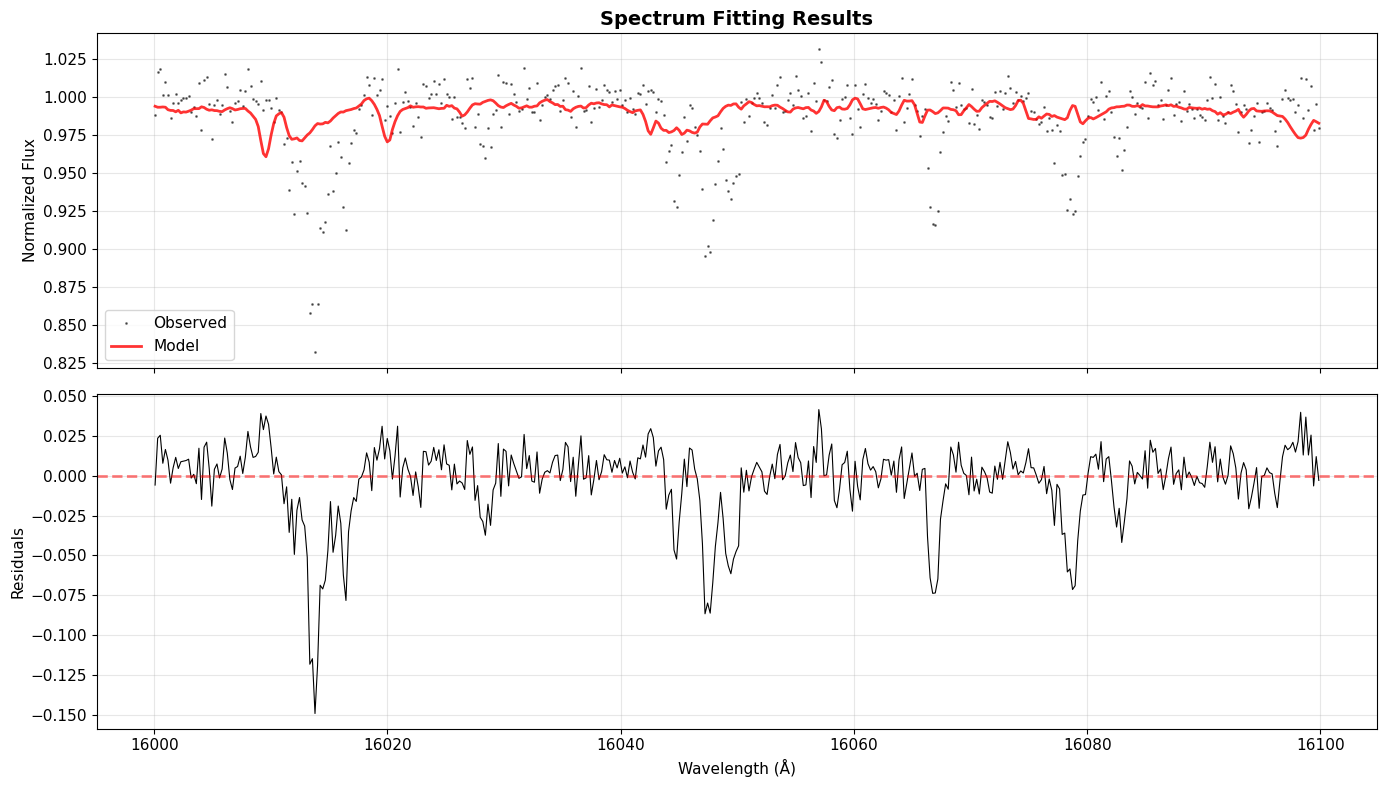

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Observed vs Model
axes[0].plot(wavelength[mask], observed_spectrum[mask], 'k.', ms=2, label='Observed', alpha=0.5)
axes[0].plot(wavelength[mask], model_spectrum[mask], 'r-', lw=2, label='Model', alpha=0.8)
axes[0].set_ylabel('Normalized Flux')
axes[0].set_title('Spectrum Fitting Results', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residuals
residuals = observed_spectrum - model_spectrum
axes[1].plot(wavelength[mask], residuals[mask], 'k-', lw=0.8)
axes[1].axhline(0, color='r', linestyle='--', lw=2, alpha=0.5)
axes[1].set_xlabel('Wavelength (Å)')
axes[1].set_ylabel('Residuals')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
<a id='summary'></a>
## 6. Summary & Best Practices

### What We Learned

✅ **Predicting Spectra**: Use `PaynePredictor` to generate synthetic spectra

✅ **Fitting Spectra**: Use `PayneFitter` to determine stellar parameters with uncertainties

✅ **Training Models**: Use `PayneTrainer` to create custom neural networks

### Best Practices

#### For Predictions:
- Check labels are within training range
- Use `get_default_labels()` as starting point
- Apply RV shifts when needed

#### For Fitting:
- Ensure continuum-normalized spectra
- Provide realistic uncertainties
- Check reduced χ² (~1 for good fit)
- Examine residuals for patterns

### Citation

📚 **Please cite**: [Ting et al. 2019, ApJ, 879, 69](https://ui.adsabs.harvard.edu/abs/2019ApJ...879...69T/abstract)

---

## 🎉 Congratulations!

You've completed The Payne tutorial. Happy spectral modeling! 🌟